<h1><center>Hopfield Model</center></h1>

<center>[bibliography:
*Information Theory, Inference and Learning Algorithms (David J. MacKay), Cambridge University Press, 2003.
*
]</center>

A Hopfield model is a fully connected feedback networks.
A feedback networks is a networks of neurons connected each others in an undirected way, the weights are so constrained to be symmetric.

<h2><center>Associative Memory</center></h2>

The usual memories of everyday use are address-based memory, that means we are forced to know an address in order to access a specific content within them. Furthermore they are not intricly fault-tolerant, the address has to be exact, and they are not distibuted, only the part of the memory that store the amount of information we want to access is not idle during the process.
Hereafter we are going to create an *associative memory* or *content-addressable memory* and we will see that it behave the opposite way a traditional memory does.
The model has been created by Donald Hebb in 1949.


#### Architecture: binary Hopfield network
Our model is controlled by the number of neurons *N* on a weighted undirected fully connected graph. We indicate the adjacency matrix (weight matrix) as ***$W$*** = $\{w_{ij}\} \in \mathcal{M}^{N\times N}$.
Each neuron has the Heaviside function as attivation function so the status of the system is an array of binary values as in the traditional computer memories. The updates may be synchronous or asynchronous.

#### Hebb Learning Rule

When Pavlov performed his famous experiment he realized how a dog, trained to receive food when a light was being turned on, established a connection between the two events and the single occurence of one of them recall in its mind also the other.
The Hebbs rule acts in the same way, strengthen the connection of neurons that fires together, in such a way that the firing of a single neuron will stimulate the other neuron to fire as well.
We want to make a number *M* of actractors our desired memories. Calling them $\{\xi^{\mu}\}_{\mu=1}^{M}$, we have the weights created as the sum of outer products:
$$w_{ij}=\frac{1}{N}\sum_{\mu=1}^M\xi_i^\mu\xi_j^\mu$$
where the $\frac{1}{N}$ term makes the weights to go as $~O(1)$ instead than as $~O(N)$.

Mapping the asynchronous Hopfield model with an Ising system it is possible to prove that the former has a Lyapunov function (the variational free energy of the Ising model) so its state space can be divided in *basin of acctraction*.

Let's now build our system.

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import lib

In [2]:
np.random.seed(9999)
def create_actractors(M, N):
    return np.array([np.random.choice([-1,1], size=N) for i in range(M)])

def create_weights(actractors):
    M = len(actractors)
    N = len(actractors[0])

    temp = np.dot(actractors.T,actractors)
    temp -= np.eye(N,dtype=np.int)*M

    return np.divide(temp,N)

In [3]:
N    = 1000
alpha = 0.02
M = np.int(alpha*N)
beta = 10000

aa = create_actractors(M, N)
w = create_weights(aa)


We now let evolve our system with a Metropolis Markov Chain Monte Carlo.
The Free Energy of the system is:
$$\mathcal{F} = -\frac{\beta}{2} x^TWx$$
where $x^TWx$ is the matrix product and $x\in\{-1,1\}^N$ is a state.

Let's $\tilde{x}$ be a proposed state.
The variation of energy, considering an asynchronous Hopfield Network, where only one spin (one perceptron) is update at every step, is:

$$
    \Delta \mathcal{F} = -\frac{\beta}{2} [\tilde{x}^TW\tilde{x}-x^TWx]
$$
Then, let the proposed flip on the $k$-spin:
$$
    \Delta \mathcal{F} = -\frac{\beta}{2} \sum_{i,j} w_{ij}[\tilde{x}_i\tilde{x}_j - x_i x_j]
$$
Since $W$ is symmetric and since only the terms where k appears are non zero, we have:
$$
    \Delta \mathcal{F} = -2\beta \sum_{i} w_{ij}\tilde{x}_i\tilde{x}_k
$$

The Metropolis MCMC will update a status only if the energy variation is negative or w.p. $e^{-\mathcal{F}}$.

In [38]:
def flip_spin(i,state):
    state[i] = -np.sign(state[i])
    return state

def codistance(actractors,state):
    N = len(state)
    return np.divide(np.dot(actractors,state),N)

def evolveMCMC(actractors, weights, state, T, beta, keeptrack=False, stop=False):
    M = len(actractors)
    N = len(state)

    if keeptrack:
        history = []
        history.append(codistance(actractors, state))

    for t in range(T-1):
        i = np.random.randint(N)
        prop = np.copy(state)
        flip_spin(i, prop)
        dE = -2*prop[i]*np.dot(weights[i], prop)

        if dE<0 or np.random.rand() < np.exp(-beta*dE):
            state = prop

        if keeptrack:
            q = codistance(actractors, state)
            history.append(q)
            if stop and np.any(np.abs(q)==1.) and t>8: 
                break
        elif stop and np.any(np.abs(codistance(actractors,state))==1.) and t>8:
            break
        
        
    if keeptrack:
        return history
    else:
        return(codistance(actractors, state))

We have also defined in the upper cell the codistance from a memory (from now on we always consider $\xi^1$ since they are all equivalent):
$$
    q(x) = \frac{1}{N} \sum_{i} \xi^1_i x_i
$$
It can be shown that the codistance is related with the Hamming distance:
$$
    d_H(\xi^1,x)=\frac{1}{4N} \sum_i |{\xi^1_i x_i}|^2
    = \frac{1}{4N}\sum_i [1+1-2\xi^1_i x_i] = \frac{1-q(x)}{2}
$$
$q(x,y)$ is one when two state are the sameand zero when they are orthogonal.

## Evolution of a perturbed actractor

In order to see that the Hopfield model act like an associative memory around the actractos we inizialize our system in a state that is a slightly perturbed version of the first actractor $\xi^1$.


#### System Parameters

* $N    = 1000$
* $\alpha = 0.02$
* $\beta = 100000$


In [5]:
def perturb_state(state, perc_errors):
    N = len(state)
    for i in range(N):
        if np.random.binomial(1,perc_errors):
            flip_spin(i, state)

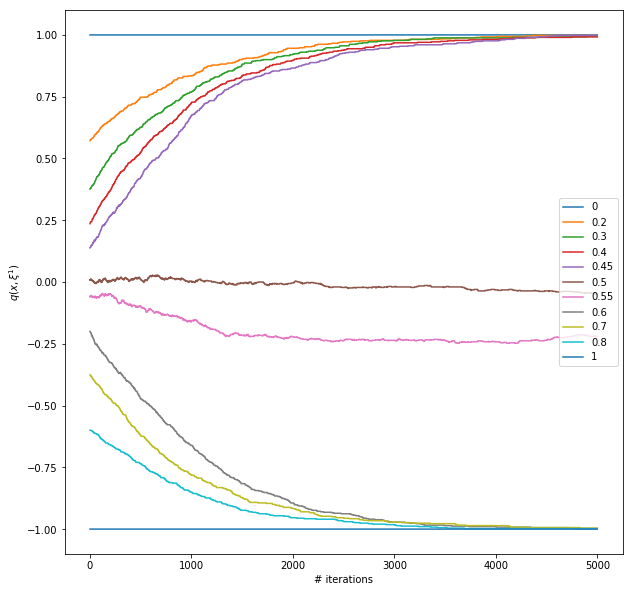

In [41]:
np.random.seed(23451569)
t = 5000
legends = [0,0.2,0.3,0.4,0.45,0.5,0.55,0.6,0.7,0.8,1]
qs = []

for l in legends:
    s = np.copy(aa[0])
    perturb_state(s, l)
    x = evolveMCMC(aa, w, s, t, beta, keeptrack=True)
    qs.append(x)

legends = [str(x) for x in legends]

plt.subplots(1,1,figsize=(10,10))
[plt.plot([i[0] for i in x], label=l) for x,l in zip(qs,legends)]
plt.legend(loc="best")
plt.xlabel("# iterations")
plt.ylabel(r"$q(x,\xi^1)$")
plt.show()

Here it has been shown the evolution of perturbed states (the probability of perturbation of each spin is shown in the legend).

## Evolution of a random state

Hereafter it is instead shown the evolution of the codistance of a random state with each actractor and how the time convergence depending on the basins of actractions can largly vary. 

### System Parameters

* $N    = 1000$
* $\alpha = 0.02$
* $\beta = 100000$


/usr/lib/python3.6/site-packages/matplotlib/axes/_axes.py:545: UserWarning: No labelled objects found. Use label='...' kwarg on individual plots.
  warnings.warn("No labelled objects found. "


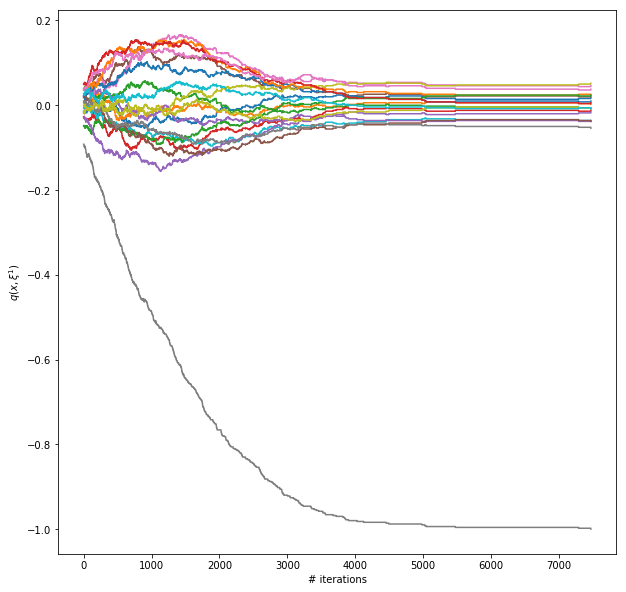

In [49]:
np.random.seed(1975861)
s = np.random.choice([-1,1], size=N)
x = evolveMCMC(aa, w, s, 20500, beta, keeptrack=True, stop=True)

plt.subplots(1,1,figsize=(10,10))
plt.plot([i for i in x])
plt.legend(loc="best")
plt.xlabel("# iterations")
plt.ylabel(r"$q(x,\xi^1)$")
plt.show()

In [37]:
np.any(x[len(x)-1]==1)
np.max(x[len(x)-1])


0.062

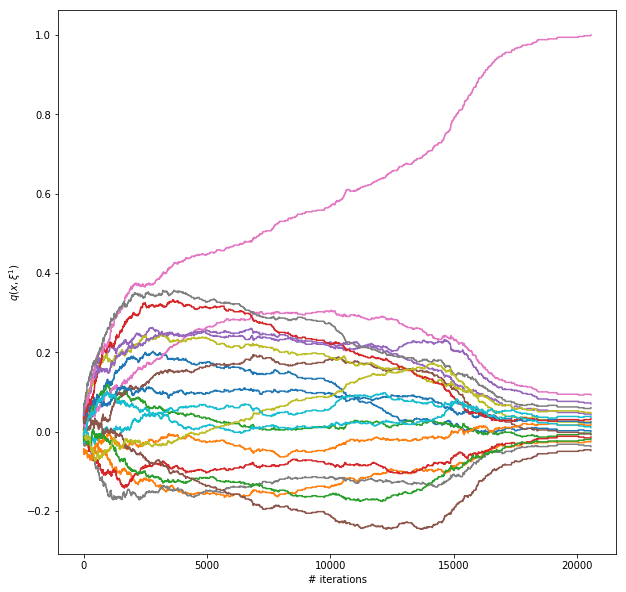

In [51]:
np.random.seed(34313451)
s = np.random.choice([-1,1], size=N)
x = evolveMCMC(aa, w, s, 26000, beta, keeptrack=True, stop=True)

plt.subplots(1,1,figsize=(10,10))
plt.plot([i for i in x])
#plt.legend(loc="best")
plt.xlabel("# iterations")
plt.ylabel(r"$q(x,\xi^1)$")
plt.show()

## General behaviour of the Hopfield Model as Associative Memory

We are now going to abserve if the Hopfield model act as an associative memory varying two of the independent parameters of the system:

* $\alpha$
* $\beta$

In fact we can see in this first example that at higher temperature T ($\beta = \frac{1}{T}$) the memory capacity of the hopfield is destroied.

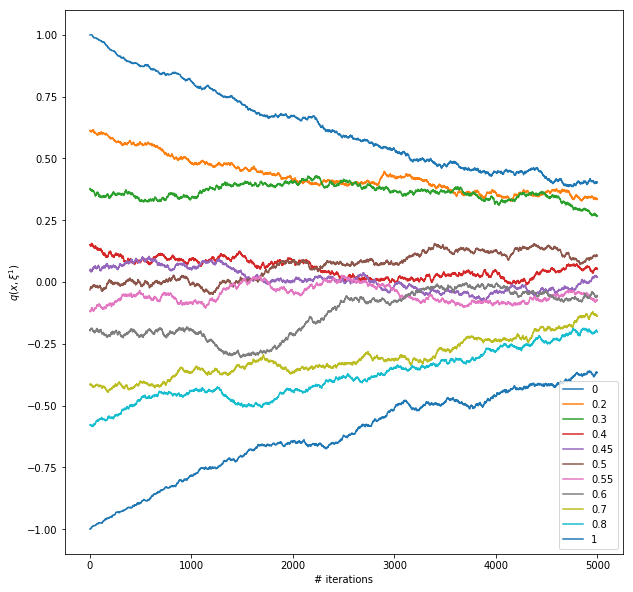

In [139]:
np.random.seed(1234)
N    = 1000
alpha = 0.02
M = np.int(alpha*N)
beta = 1

aa = create_actractors(M, N)
w = create_weights(aa)

np.random.seed(23451569)
t = 5000
legends = [0,0.2,0.3,0.4,0.45,0.5,0.55,0.6,0.7,0.8,1]
qs = []

for l in legends:
    s = np.copy(aa[0])
    perturb_state(s, l)
    x = evolveMCMC(aa, w, s, t, beta, keeptrack=True)
    qs.append(x)

legends = [str(x) for x in legends]

plt.subplots(1,1,figsize=(10,10))
[plt.plot([i[0] for i in x], label=l) for x,l in zip(qs,legends)]
plt.legend(loc="best")
plt.xlabel("# iterations")
plt.ylabel(r"$q(x,\xi^1)$")
plt.show()

In [137]:
alphas = np.arange(0.05,1.01,0.05)
Ts = np.arange(0.1, 2.1, 0.2)
betas = 1/Ts
qs = np.zeros(shape=(len(betas),len(alphas)))
qs.shape

(10, 20)

In [138]:
np.random.seed(1234)
for i,beta in enumerate(betas):
    print(beta)
    for j,alpha in enumerate(alphas):
        alpha = 0.02
        M = np.int(alpha*N)
        aa = create_actractors(M, N)
        w = create_weights(aa)
        s = np.copy(aa[0])
        perturb_state(s, 0.2)
        q = evolveMCMC(aa, w, s, 25000, beta, keeptrack=False, stop=True)
        qs[i,j] = np.max(np.abs(q))

10.0
3.33333333333
2.0
1.42857142857
1.11111111111
0.909090909091
0.769230769231
0.666666666667
0.588235294118
0.526315789474


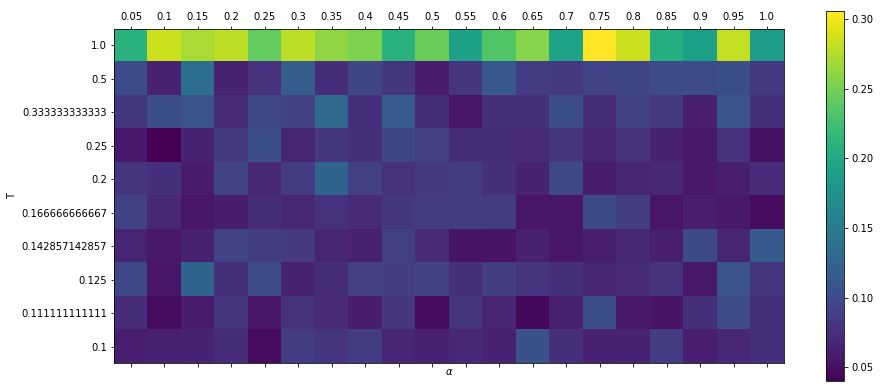

In [135]:
from matplotlib import ticker
fig = plt.figure(figsize=(15,15))
ax_hist = plt.subplot(211)
plt.xlabel(r"$\alpha$")
plt.ylabel("T")
cax = ax_hist.matshow(qs) 
fig.colorbar(cax)
ax_hist.xaxis.set_major_locator(ticker.MultipleLocator(1))
ax_hist.yaxis.set_major_locator(ticker.MultipleLocator(1))
ax_hist.set_xticklabels(np.r_[[0],alphas])
ax_hist.set_yticklabels(np.r_[[0],betas])

#ax_plot = plt.subplot(212, sharex=ax_hist)
#plt.xlabel("$\alpha$")
#plt.ylabel("q")
#x = qs[50:]
#y = Ts
#ax_plot.plot()


plt.show()

In [127]:
alphas

array([ 0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,  0.45,
        0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,  0.9 ,
        0.95,  1.  ])